In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from time import time
from scipy.optimize import curve_fit

In [3]:
gaz_zcta_years = [2000, 2010, 2012, 2013, 2014, 2015, 2016]
gaz_zcta = []
for y in gaz_zcta_years:
    fname = 'gaz_zcta' + str(y) + '.csv'
    gaz = pd.read_csv(fname, sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
    gaz_zcta.append(gaz)

print(len(gaz_zcta), '개 로드 완료!')

def which_gaz(year):
    test = [abs(year-zear) for zear in gaz_zcta_years]
    return gaz_zcta[test.index(min(test))]

7 개 로드 완료!


In [4]:
class Year_read:
    def __init__(self, prefix, year):
        self.year = year
        self.gaz = which_gaz(year)

        fname = prefix + str(year) + '.csv'
        self.zbp = pd.read_csv(fname, header=(0), dtype={'EMP':int, 'ZIP':str, 'rho':float})

### Reading Files & Attaching Population Info

In [5]:
years = np.arange(1999, 2017)
dat = []
for y in years:
    dat.append(Year_read('dat', y))

tflag = time()
for i,d in enumerate(dat):
    for row in d.zbp.iloc:
        idx = row.index_gaz
        if not np.isnan(idx):
            idx = int(idx)
            pop = d.gaz.iloc[idx].POP
            d.zbp.loc[row.name, 'POP'] = pop
    print(i+1, '/', len(dat), '(', d.year, ')', time()-tflag, 'sec'); tflag = time()
    
ykp = pd.read_csv('ykp_0824_alpha_5.csv', sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
ykp_5 = ykp.copy()
ykp_10 = pd.read_csv('ykp_0824_alpha_5.csv', sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
ykp_20 = pd.read_csv('ykp_0824_alpha_5.csv', sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
ykp.head()

1 / 18 ( 1999 ) 11.656026601791382 sec
2 / 18 ( 2000 ) 12.209590673446655 sec
3 / 18 ( 2001 ) 12.343568801879883 sec
4 / 18 ( 2002 ) 12.893512964248657 sec
5 / 18 ( 2003 ) 13.444451570510864 sec
6 / 18 ( 2004 ) 12.671076536178589 sec
7 / 18 ( 2005 ) 12.722790718078613 sec
8 / 18 ( 2006 ) 12.984569787979126 sec
9 / 18 ( 2007 ) 12.506586790084839 sec
10 / 18 ( 2008 ) 13.880374908447266 sec
11 / 18 ( 2009 ) 13.714733362197876 sec
12 / 18 ( 2010 ) 13.286051034927368 sec
13 / 18 ( 2011 ) 13.318702697753906 sec
14 / 18 ( 2012 ) 13.064074754714966 sec
15 / 18 ( 2013 ) 13.096916913986206 sec
16 / 18 ( 2014 ) 13.172640085220337 sec
17 / 18 ( 2015 ) 13.321985960006714 sec
18 / 18 ( 2016 ) 13.288827180862427 sec


,Y,GEO_TTL,k,P
0,1999,"Aaronsburg, PA",1,1091.0
1,1999,"Abbeville, AL",1,6991.0
2,1999,"Abbeville, GA",1,3870.0
3,1999,"Abbeville, LA",1,24760.0
4,1999,"Abbeville, MS",1,2272.0


In [303]:
ykp = pd.read_csv('ykp_0824_alpha_20.csv', sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
# ykp = pd.read_csv('ykp_0824_alpha_10.csv', sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})
# ykp = pd.read_csv('ykp_0824_alpha_5.csv', sep=',', header=(0), dtype={'GEOID':str, 'ALAND':float})

In [311]:
g = ykp.groupby(['GEO_TTL'])
X = g['k'].apply(lambda v: round(np.median(v))).to_numpy()
X_D = g['k'].apply(lambda v: max(v)-min(v)).to_numpy()
Y = g['P'].apply(np.median).to_numpy()
Y_D = g['P'].apply(lambda v: max(v)-min(v)).to_numpy()

kp = pd.DataFrame({'k':X, 'P':Y})
h = kp.groupby(['k'])
X_avg = list(h.indices)
Y_avg = h['P'].mean()

fitfunc = lambda x,a,b : a*(x**b)
param, cov = curve_fit(fitfunc, X_avg[1:-5], Y_avg[1:-5])
Xfit = X_avg.copy()
Yfit = fitfunc(Xfit, *pfit)

Pstar = param[0]
delta = param[1]
std = np.sqrt(np.diag(cov))
R_sq = np.corrcoef(np.log(Y_avg[1:None]), np.log(Yfit[1:None]))[0,1]**2

print(len(X))
print('pfit :', pfit)

18901
pfit : [3.66501650e+04 1.03173738e+00]


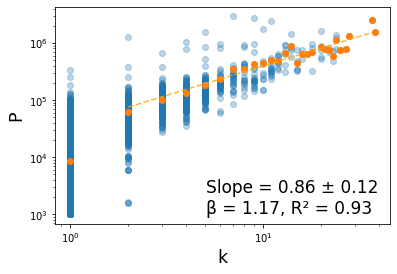

In [312]:
fig, ax = plt.subplots()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('k', fontsize='xx-large'); ax.set_ylabel('P', fontsize='xx-large')

ax.scatter(X, Y, alpha = 0.3)
ax.scatter(X_avg, Y_avg)
ax.plot(Xfit[1:-1], Yfit[1:-1], ls='--', color='orange', alpha=0.8)

antext = 'Slope = {:.2f} ± {:.2f} \nβ = {:.2f}, R² = {:.2f}'.format(delta, std[1], 1/delta, R_sq)
ax.annotate(antext, (0.45, 0.05), xycoords='axes fraction', fontsize=17)

plt.show()

In [308]:
X = ykp['k'].to_numpy()
Y = ykp['P'].to_numpy()

kp = pd.DataFrame({'k':X, 'P':Y})
h = kp.groupby(['k'])
X_avg = list(h.indices)
Y_avg = h['P'].mean()

fitfunc = lambda x,a,b : a*(x**b)
pfit, cov = curve_fit(fitfunc, X_avg[1:-1], Y_avg[1:-1])
Xfit = X_avg.copy()
Yfit = fitfunc(Xfit, *pfit)

Pstar = pfit[0]
delta = pfit[1]
std = np.sqrt(np.diag(cov))
R_sq = np.corrcoef(np.log(Y_avg[1:-1]), np.log(Yfit[1:-1]))[0,1]**2

print('pfit :', pfit)

pfit : [3.66501650e+04 1.03173738e+00]


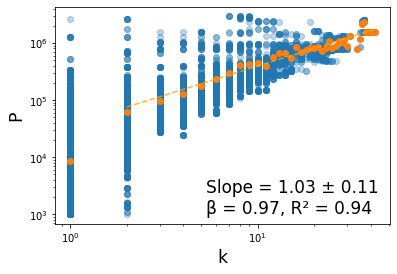

In [309]:
fig, ax = plt.subplots()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('k', fontsize='xx-large'); ax.set_ylabel('P', fontsize='xx-large')

ax.scatter(X, Y, alpha = 0.3)
ax.scatter(X_avg, Y_avg)
ax.plot(Xfit[1:-1], Yfit[1:-1], ls='--', color='orange', alpha=0.8)

antext = 'Slope = {:.2f} ± {:.2f} \nβ = {:.2f}, R² = {:.2f}'.format(delta, std[1], 1/delta, R_sq)
ax.annotate(antext, (0.45, 0.05), xycoords='axes fraction', fontsize=17)

plt.show()

In [299]:
Y_avg

k
1     1.013852e+04
2     8.236207e+04
3     1.721870e+05
4     2.129857e+05
5     3.014123e+05
6     3.470933e+05
7     5.123989e+05
8     4.835724e+05
9     5.369207e+05
10    5.926948e+05
11    6.103224e+05
12    8.348552e+05
13    9.310923e+05
14    1.234802e+06
15    1.925003e+06
16    2.485013e+06
17    1.194998e+06
18    1.537172e+06
19    1.766085e+06
20    1.521518e+06
21    1.560973e+06
22    1.577385e+06
23    1.577385e+06
24    1.552768e+06
25    1.552768e+06
Name: P, dtype: float64